### Importing Libraries

In [1]:
from nltk.corpus import wordnet as wn
import http.client
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

### Task 1 : Data Identification : Identify one or more suitable web APIs¶

The API chosen for this assignment is <b>Food Calorie Data Search</b>. The API is available freely over Rapid API website. Therefore, we can easily download calorie data for a food item one at a time. The link to access the dataset is: https://rapidapi.com/kenpi04/api/food-calorie-data-search/endpoints <br> We need to login at Rapid API website which can give us api-key to play around the editor with API end-points.

### Task 2 : Data Collection : Calling API and getting data for selective fruits

The API can get the data for each food item one at a time. Therefore, we need to call the values for one food item at a time. I chose to get the data of <u>fruits</u>. <br>
For this I used a Fruit corpus available over <u>nltk.corpus wordnet</u>. From that corpus, I manually chose 12 different fruits and then made analysis over those values. <br>
The data returned is of a particular food item contained in a group of meals. 10 records are returned per api call.

#### Taking Fruit data from corpus

In [2]:
# extracting fruit data from wordnet synset data
fruits = wn.synset('fruit.n.01')
# getting list of fruits from lemma
fruit_data = list(set([w for s in fruits.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

# for each record in the list remove special characters like ' and _ to get only words
for i in fruit_data:
    if "'" in i:
        fruit_data.remove(i)
    if '_' in i:
        i = i.replace('_',' ')

#replace _ and ' with blank
fruit_data = [i.replace('_',' ') for i in fruit_data]
fruit_data = [i.replace("'",' ') for i in fruit_data]

# printing the fruit words
print(fruit_data)

['ketembilla', 'genip', 'schizocarp', 'marasca', 'honeydew melon', 'saskatoon', 'hog plum', 'May apple', 'quantong', 'sweet calabash', 'chincapin', 'acinus', 'citrus fruit', 'cherimolla', 'dewberry', 'groundnut', 'mammee apple', 'coquilla nut', 'morello', 'beach plum', 'legume', 'Winesap', 'marmalade plum', 'mango', 'netted melon', 'kola nut', 'palm nut', 'Stayman Winesap', 'avocado', 'caryopsis', 'chokecherry', 'seckel', 'sapodilla plum', 'jack', 'grain', 'cobnut', 'pond apple', 'currant', 'sour cherry', 'key lime', 'coffee', 'cumin seed', 'Pippin', 'bosc', 'shaddock', 'seckel pear', 'Seville orange', 'mangosteen', 'sunflower seed', 'gooseberry', 'algarobilla', 'hickory nut', 'vinifera grape', 'castor bean', 'cowpea', 'flame tokay', 'sweetsop', 'star fruit', 'kai apple', 'dika nut', 'Mexican black cherry', 'alligator pear', 'boysenberry', 'pineapple guava', 'jujube', 'Baldwin', 'safflower seed', 'Chinese gooseberry', 'cashew nut', 'wintergreen', 'edible seed', 'casaba', 'grapefruit', 

###### Note: Run entire notebook in one go if you face error like below:
<b> TypeError: 'list' object is not callable </b>

### Connecting to API and getting data for selective fruits

In [3]:
# making connection request to the domain
conn = http.client.HTTPSConnection("food-calorie-data-search.p.rapidapi.com")

#setting headers with host and key values - provided after logging in rapidapi
headers = {
    'x-rapidapi-host': "food-calorie-data-search.p.rapidapi.com",
    'x-rapidapi-key': "5bf192c5cemsh6925a9e00884d04p102f48jsn05bc359e0d8f"
    }

#list to store results
results=[]

#list of selective fruits chosen from the Fruit corpus above
list=['hazelnut','cherry','muskmelon','bean','raspberry','chickpea','coffee bean','litchi','peach','butternut','olive','pear','strawberry',\
      'sweet melon','melon']

#iterate through each word and call the food-calorie api for each 
for str_ in list:
    #calling the api with each fruit value one by one
    conn.request("GET", "/api/search?keyword="+str_, headers=headers)
    res = conn.getresponse()
    #reading data from the response
    data = res.read()
    data = data.decode("utf-8")
    #removing all special characters and empty data and storing in json format
    if data not in '' and data not in '[]':
        data = json.loads(data)
        for i in data:
            i['fruit_name']=str_
        results.append(data)

### Making list of Dataframes

The data we have now is in form of List of JSON objects, we need to convert each JSON object to dataframe. Thus, finally we get <u>List of Dataframes.</u>

In [4]:
df = pd.DataFrame()

list_of_df=[]

#for each JSON object, convert to data frame and store in list_of_df list
for i in results:
    df = pd.DataFrame(i)
    list_of_df.append(df)

### Saving Data in CSV file

In [5]:
csv_data = pd.DataFrame()

#for each data frame in list, store in a common data frame, then store this file to csv
for i in list_of_df:
    csv_data = csv_data.append(i, ignore_index=True)

csv_data.to_csv('fruits_data.csv')

### Task 3 : Data preparation and analysis:

#### Pre-processing Data

We would have a list of dataframes where each dataframe looks like the following:

In [6]:
list_of_df[0]

,id,ndb_no,shrt_desc,water,energ_kcal,protein,lipid_tot,ash,carbohydrt,fiber_td,...,fa_sat,fa_mono,fa_poly,cholestrl,gmwt_1,gmwt_desc1,gmwt_2,gmwt_desc2,refuse_pct,fruit_name
0,1353,4532,"OIL,HAZELNUT",0.00,884,0.00,100.00,0.00,0.00,0.0,...,7.400,78.000,10.200,0,13.60,1 tablespoon,218.00,1 cup,0,hazelnut
1,2527,8689,"CEREALS,QUAKER,OATMEAL,REAL MEDLEYS,BLUEBERRY ...",7.47,386,9.81,9.80,3.46,69.47,7.7,...,1.648,3.742,2.863,1,70.00,"1 package, (1 NLEA serving)",0.00,,0,hazelnut
2,2995,19125,CHOCOLATE-FLAVORED HAZELNUT SPRD,1.07,541,5.41,29.73,1.44,62.16,5.4,...,28.423,0.000,0.000,0,37.00,"1 serving, 2 TBSP",0.00,,0,hazelnut
3,5105,35233,"HAZELNUTS,BEAKED (NORTHERN PLAINS INDIANS)",5.92,628,14.89,52.99,3.22,22.98,9.8,...,0.000,0.000,0.000,0,0.40,1 nut,28.35,1 oz,0,hazelnut
4,6486,12120,HAZELNUTS OR FILBERTS,5.31,628,14.95,60.75,2.29,16.70,9.7,...,4.464,45.652,7.920,0,115.00,"1 cup, chopped",75.00,"1 cup, ground",59,hazelnut
5,6487,12121,"HAZELNUTS OR FILBERTS,BLANCHED",5.79,629,13.70,61.15,2.36,17.00,11.0,...,4.669,48.192,5.558,0,28.35,1 oz,0.00,,0,hazelnut
6,6488,12122,"HAZELNUTS OR FILBERTS,DRY RSTD,WO/SALT",2.52,646,15.03,62.40,2.45,17.60,9.4,...,4.511,46.608,8.463,0,28.35,1 oz,0.00,,0,hazelnut
7,8248,16262,SILK HAZELNUT CREAMER,72.95,133,0.00,6.67,0.38,20.00,0.0,...,0.000,0.000,0.000,0,15.00,1 tbsp,0.00,,0,hazelnut


#### Extracting specific columns from the dataset

The data we currently recieved have many <u>irrelevant and unneccessay</u> fields like - <u>id, ndb_no, short description, gram weight etc.</u> Those are difficult to understand, therefore, we would consider only specific fields which we can analyze and draw patterns from.

In [7]:
# considered only the fields which makes sense and are important for us
for i in range(len(list_of_df)):
    fruit = list_of_df[i]
    list_of_df[i] = fruit[["fruit_name","calcium","carbohydrt","copper","energ_kcal","iron","magnesium","manganese","phosphorus",\
                "protein","selenium","sodium","vit_b12","vit_b6","vit_c","vit_e","vit_k","water","zinc"]]


Now, we have a list of dataframes like the following:

In [8]:
list_of_df[0]

,fruit_name,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
0,hazelnut,0,0.00,0.000,884,0.00,0,0.000,0,0.00,0.0,0,0.00,0.000,0.0,47.20,0.0,0.00,0.00
1,hazelnut,64,69.47,0.000,386,3.08,98,0.000,287,9.81,0.0,337,0.00,0.127,2.8,0.45,0.0,7.47,2.15
2,hazelnut,108,62.16,0.469,541,4.38,64,0.868,152,5.41,3.6,41,0.27,0.082,0.0,4.96,1.9,1.07,1.06
3,hazelnut,441,22.98,1.200,628,3.12,235,7.600,411,14.89,0.0,2,0.00,0.550,0.0,0.00,0.0,5.92,2.06
4,hazelnut,114,16.70,1.725,628,4.70,163,6.175,290,14.95,2.4,0,0.00,0.563,6.3,15.03,14.2,5.31,2.45
5,hazelnut,149,17.00,1.600,629,3.30,160,12.650,310,13.70,4.1,0,0.00,0.585,2.0,17.50,0.0,5.79,2.20
6,hazelnut,123,17.60,1.750,646,4.38,173,5.550,310,15.03,4.1,0,0.00,0.620,3.8,15.28,0.0,2.52,2.50
7,hazelnut,0,20.00,0.000,133,0.00,0,0.000,0,0.00,0.0,67,0.00,0.000,200.0,0.00,0.0,72.95,0.00


##### Normalize Data 
As the values of different fields are in varied range, we need to scale this to match all columns equally. <br>
For this I have performed Min Max scaling from Sklearn pre-processing library. <br>
All values would be recuded to minimal after performing this step.

In [9]:
for fruits in list_of_df: 
    for k in fruits:
        if k not in 'fruit_name':
            x = fruits[k].values.astype(float) #returns a numpy array
            x = x.reshape(-1, 1)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            fruits[k] = pd.DataFrame(x_scaled)
            
list_of_df[0]

,fruit_name,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
0,hazelnut,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,1.000000,0.000000,0.000000,0.000
1,hazelnut,0.145125,1.000000,0.000000,0.336884,0.655319,0.417021,0.000000,0.698297,0.652695,0.000000,1.000000,0.0,0.204839,0.0140,0.009534,0.000000,0.102399,0.860
2,hazelnut,0.244898,0.894775,0.268000,0.543276,0.931915,0.272340,0.068617,0.369830,0.359947,0.878049,0.121662,1.0,0.132258,0.0000,0.105085,0.133803,0.014668,0.424
3,hazelnut,1.000000,0.330790,0.685714,0.659121,0.663830,1.000000,0.600791,1.000000,0.990685,0.000000,0.005935,0.0,0.887097,0.0000,0.000000,0.000000,0.081151,0.824
4,hazelnut,0.258503,0.240392,0.985714,0.659121,1.000000,0.693617,0.488142,0.705596,0.994677,0.585366,0.000000,0.0,0.908065,0.0315,0.318432,1.000000,0.072790,0.980
5,hazelnut,0.337868,0.244710,0.914286,0.660453,0.702128,0.680851,1.000000,0.754258,0.911510,1.000000,0.000000,0.0,0.943548,0.0100,0.370763,0.000000,0.079369,0.880
6,hazelnut,0.278912,0.253347,1.000000,0.683089,0.931915,0.736170,0.438735,0.754258,1.000000,1.000000,0.000000,0.0,1.000000,0.0190,0.323729,0.000000,0.034544,1.000
7,hazelnut,0.000000,0.287894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.198813,0.0,0.000000,1.0000,0.000000,0.000000,1.000000,0.000


#### Check if any Missing Data

There is no data missing in any of the dataframes.

In [10]:
missing_values=0

#for each of the fruit data in list, check if there are any missing values
for fruits in list_of_df:
    missing_values += fruits.isnull().sum()

missing_values.sum()

0

In [11]:
missing_values=0

#for each of the fruit data in list, check if there are any NaN values
for fruits in list_of_df:
    missing_values += fruits.dtypes.value_counts()

missing_values

float64    216
object      12
dtype: int64

There is no NaN or empty strings found in the data. Therefore, the data is clean and good to use.

### Analyse and summarise the cleaned dataset

#### For fruit 'Bean' plot between different elements

In [12]:
#extract the data of "Bean" fruit from the list of data we have
bean = pd.DataFrame()

#Store the data of 'bean' fruit in a seperate dataframe
for i in list_of_df:
    if 'bean' == i['fruit_name'][0]:
        bean = i
        
bean        

,fruit_name,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
0,bean,0.38,0.652284,1.000000,0.468750,0.733333,0.891892,0.833333,0.595238,0.465251,0.000000,1.000000,0.000000,0.70,0.037037,0.413793,0.352941,0.383032,1.000000
1,bean,0.88,0.783418,1.000000,0.864583,0.761905,0.891892,0.833333,0.777778,0.667954,0.927536,0.619413,0.500000,0.31,0.407407,1.000000,0.470588,0.123996,0.700000
2,bean,1.00,0.764805,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.822478,1.000000,1.00,0.222222,0.000000,0.000000,0.000000,0.818182
3,bean,0.32,0.291878,0.533333,0.510417,0.571429,0.513514,0.483333,0.468254,0.534749,1.000000,0.272031,0.500000,0.50,0.629630,0.000000,0.000000,0.548695,0.400000
4,bean,0.62,1.000000,0.000000,0.822917,0.647619,0.000000,0.000000,0.000000,0.739382,0.000000,0.619413,0.000000,0.00,1.000000,0.000000,0.000000,0.125502,0.000000
5,bean,0.44,0.503384,0.273333,0.364583,0.276190,0.513514,0.380000,0.103175,0.341699,0.623188,0.000000,0.500000,0.46,0.370370,0.448276,1.000000,0.612952,0.481818
6,bean,0.00,0.210660,0.000000,0.510417,0.000000,0.000000,0.000000,0.000000,0.714286,0.000000,0.214559,0.000000,0.00,0.148148,0.000000,0.000000,0.552209,0.000000
7,bean,0.06,0.000000,0.516667,0.000000,0.019048,0.459459,0.416667,0.301587,0.000000,0.000000,0.383142,0.000000,0.35,0.000000,0.206897,0.176471,1.000000,0.500000
8,bean,0.30,0.050761,0.506667,0.177083,0.019048,0.459459,0.408333,0.380952,0.088803,0.449275,0.206897,0.166667,0.15,0.185185,0.494253,0.235294,0.886044,0.345455
9,bean,0.00,0.210660,0.000000,0.510417,0.000000,0.000000,0.000000,0.000000,0.714286,0.000000,0.219668,0.000000,0.00,0.148148,0.000000,0.000000,0.552209,0.000000


#### Describing the data of Bean Fruit
The describe function gives the values of different agggregation functions as shown below.

In [13]:
bean.describe()

,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.400000,0.446785,0.483000,0.522917,0.402857,0.472973,0.435500,0.362698,0.526641,0.400000,0.435760,0.266667,0.34700,0.314815,0.256322,0.223529,0.478464,0.424545
std,0.348457,0.342847,0.414986,0.308376,0.382722,0.380571,0.366764,0.351146,0.310342,0.453448,0.316726,0.344265,0.33143,0.305041,0.333710,0.321951,0.326647,0.352534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.120000,0.210660,0.068333,0.390625,0.019048,0.114865,0.095000,0.025794,0.372587,0.000000,0.215837,0.000000,0.03750,0.148148,0.000000,0.000000,0.189885,0.086364
50%,0.350000,0.397631,0.511667,0.510417,0.423810,0.486486,0.412500,0.341270,0.601351,0.224638,0.327586,0.083333,0.33000,0.203704,0.103448,0.088235,0.550452,0.440909
75%,0.575000,0.736675,0.883333,0.744792,0.711905,0.797297,0.745833,0.563492,0.714286,0.851449,0.619413,0.500000,0.49000,0.398148,0.439655,0.323529,0.597766,0.650000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Finding Correlation between elements of Bean

Construction of a heatmap which would help us find the approximate relation between data fields. <br>
The more positive value of correlation coefficient represents direct proportionality and negative indicates inverse proportionality. The figure below represents cream color for positive correlation and blue shades for negative correlation. It is easier with the colors that we could tell that how much two fields are proportional to each other.

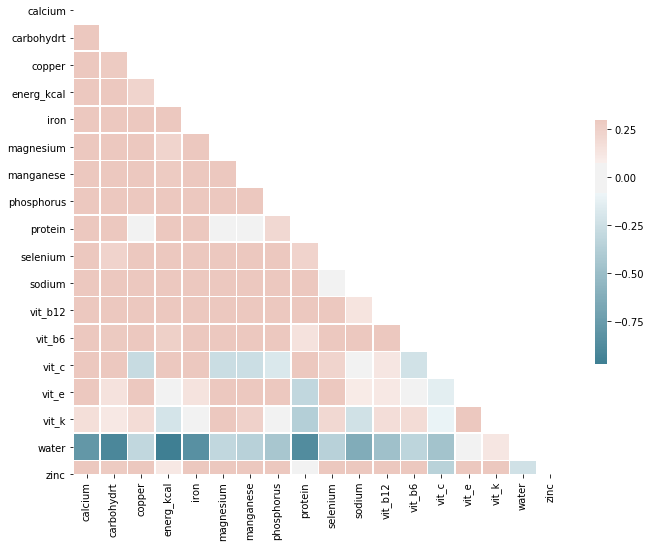

In [14]:
# variable to store correlation
corr = bean.corr()

# Hiding the upper triangle so that we get asymmetric triangle for data relation
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Drawing heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the heatmap we can see that calcium, carbohydrate, copper, energy kcal, iron are related to many fields directly and have a quiet very positive relation. <br>
Water is extremely inversely proportional to many fields like - Calcium, Carohydrate. Energy kilo-calorie, protein.

##### Finding relation between energy kilo-calories and different elements using Scatter Plots

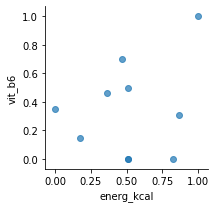

In [15]:
#plotting using seaborn Face Grid function
g = sns.FacetGrid(bean)
g.map(plt.scatter, "energ_kcal", "vit_b6", alpha=.7)
g.add_legend();

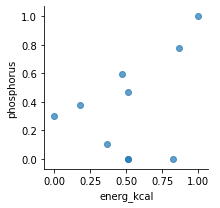

In [16]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "energ_kcal", "phosphorus", alpha=.7)
g.add_legend();

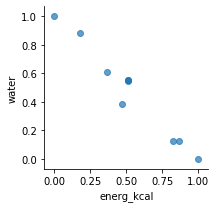

In [17]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "energ_kcal", "water", alpha=.7)
g.add_legend();

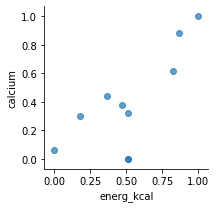

In [18]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "energ_kcal", "calcium", alpha=.7)
g.add_legend();

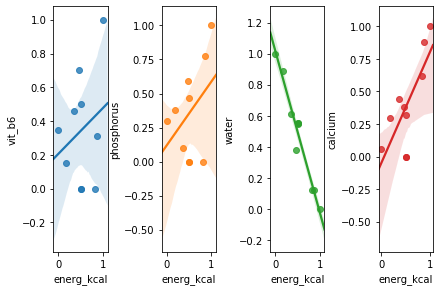

In [19]:
#finding relation comparison between Vitamin B6, Phosphorus, Water and Calcium with Energy Kilo Calores
fig, axs = plt.subplots(ncols=4)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
sns.regplot(x='energ_kcal', y='vit_b6', data=bean, ax=axs[0])
sns.regplot(x='energ_kcal', y='phosphorus', data=bean, ax=axs[1])
sns.regplot(x='energ_kcal',y='water', data=bean, ax=axs[2])
sns.regplot(x='energ_kcal',y='calcium', data=bean, ax=axs[3])

<b>Plot Observations:</b>
Energy Kilo Calories is directly propoertional to Vitamin B6, Phosphorus, Calcium and inversely proportional to Water and Calcium when Bean is consumed with your meal.

#### Similarly, plotting for Iron vs other elements

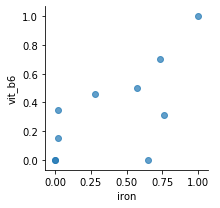

In [20]:
#plotting using seaborn Face Grid function
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "vit_b6", alpha=.7)
g.add_legend();

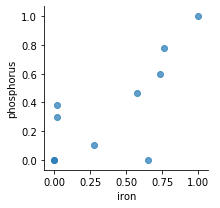

In [21]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "phosphorus", alpha=.7)
g.add_legend();

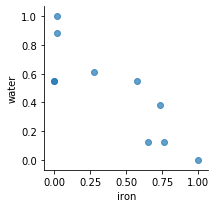

In [22]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "water", alpha=.7)
g.add_legend();

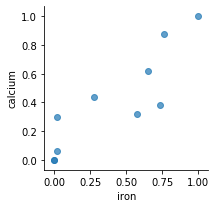

In [23]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "calcium", alpha=.7)
g.add_legend();

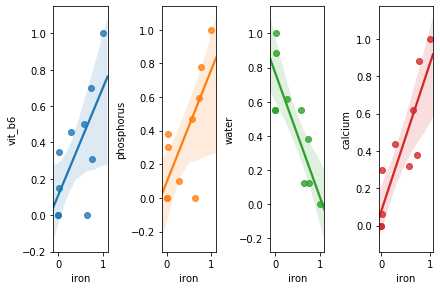

In [24]:
#finding relation comparison between Vitamin B6, Phosphorus, Water and Calcium with Energy Kilo Calores
fig, axs = plt.subplots(ncols=4)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
sns.regplot(x='iron', y='vit_b6', data=bean, ax=axs[0])
sns.regplot(x='iron', y='phosphorus', data=bean, ax=axs[1])
sns.regplot(x='iron',y='water', data=bean, ax=axs[2])
sns.regplot(x='iron',y='calcium', data=bean, ax=axs[3])

<b>Plot Observations:</b>
Iron is directly proportional to Vitamin B6, Phosphorus and Calcium; and inversely proportional to Water when Bean is consumed in you meal.

### For 'Peach' fruit plot between different elements

In [25]:
peach = pd.DataFrame()

for i in list_of_df:
    if 'peach' == i['fruit_name'][0]:
        peach = i
        
peach.describe()     

,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.158824,0.195612,0.442857,0.151429,0.148148,0.128696,0.248000,0.123841,0.131313,0.290000,0.135323,0.100000,0.232174,0.377358,0.326829,0.284848,0.835924,0.157798
std,0.315991,0.287944,0.437758,0.299587,0.303433,0.307049,0.405539,0.308424,0.307423,0.398469,0.306542,0.316228,0.337704,0.325113,0.392983,0.400413,0.296214,0.300265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009804,0.077403,0.153061,0.046429,0.023148,0.017391,0.000000,0.016556,0.010101,0.000000,0.019900,0.000000,0.008696,0.127358,0.015244,0.000000,0.895690,0.022936
50%,0.019608,0.126212,0.170918,0.072857,0.048148,0.021739,0.000000,0.018212,0.020202,0.100000,0.039801,0.000000,0.104348,0.295991,0.126016,0.121212,0.910825,0.052752
75%,0.075980,0.159655,0.906888,0.080000,0.082407,0.060870,0.555000,0.049669,0.074747,0.375000,0.044776,0.000000,0.256522,0.620873,0.691057,0.371212,0.948813,0.128440
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Finding Correlation between elements of Peach
Construction of a heatmap which would help us find the approximate relation between data fields. <br>
The more positive value of correlation coefficient represents direct proportionality and negative indicates inverse proportionality. The figure below represents cream color for positive correlation and blue shades for negative correlation. It is easier with the colors that we could tell that how much two fields are proportional to each other.

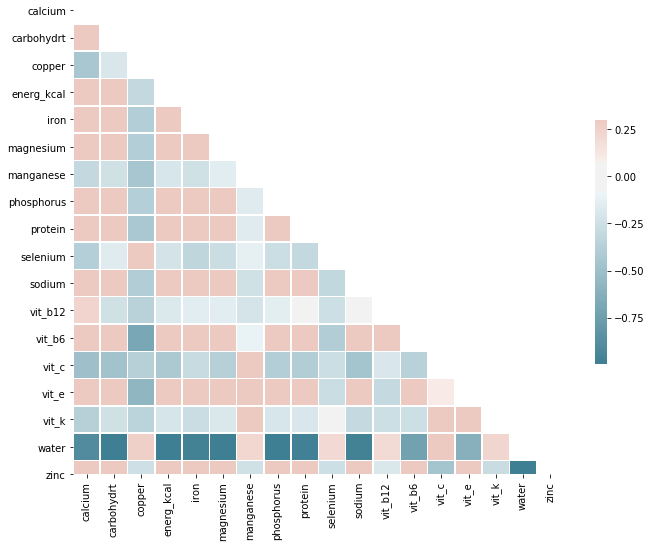

In [26]:
corr = peach.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
peach.describe()

,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.158824,0.195612,0.442857,0.151429,0.148148,0.128696,0.248000,0.123841,0.131313,0.290000,0.135323,0.100000,0.232174,0.377358,0.326829,0.284848,0.835924,0.157798
std,0.315991,0.287944,0.437758,0.299587,0.303433,0.307049,0.405539,0.308424,0.307423,0.398469,0.306542,0.316228,0.337704,0.325113,0.392983,0.400413,0.296214,0.300265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.009804,0.077403,0.153061,0.046429,0.023148,0.017391,0.000000,0.016556,0.010101,0.000000,0.019900,0.000000,0.008696,0.127358,0.015244,0.000000,0.895690,0.022936
50%,0.019608,0.126212,0.170918,0.072857,0.048148,0.021739,0.000000,0.018212,0.020202,0.100000,0.039801,0.000000,0.104348,0.295991,0.126016,0.121212,0.910825,0.052752
75%,0.075980,0.159655,0.906888,0.080000,0.082407,0.060870,0.555000,0.049669,0.074747,0.375000,0.044776,0.000000,0.256522,0.620873,0.691057,0.371212,0.948813,0.128440
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Finding relation between iron and different elements using Scatter Plots

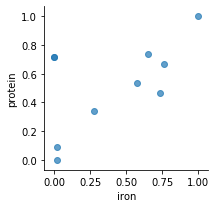

In [28]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "protein", alpha=.7)
g.add_legend();

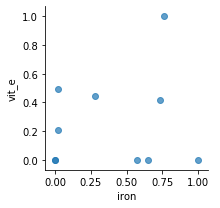

In [29]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "vit_e", alpha=.7)
g.add_legend();

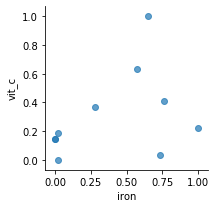

In [30]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "vit_c", alpha=.7)
g.add_legend();

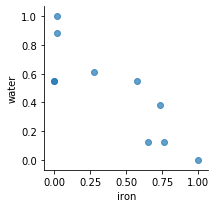

In [31]:
g = sns.FacetGrid(bean)
g.map(plt.scatter, "iron", "water", alpha=.7)
g.add_legend();

Text(0.5, 1, 'Relation plot of Iron with Protein, Vitamin E, Vitamin C and Water')

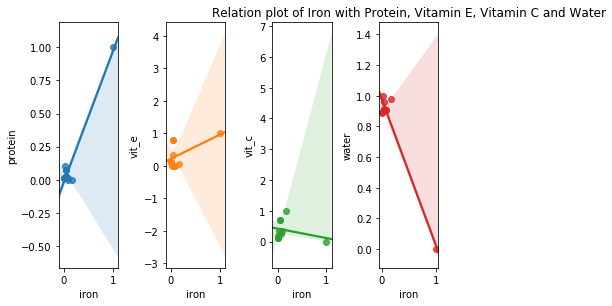

In [32]:
fig, axs = plt.subplots(ncols=4)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
sns.regplot(x='iron', y='protein', data=peach, ax=axs[0])
sns.regplot(x='iron', y='vit_e', data=peach, ax=axs[1])
sns.regplot(x='iron',y='vit_c', data=peach, ax=axs[2])
sns.regplot(x='iron',y='water', data=peach, ax=axs[3])
plt.title("Relation plot of Iron with Protein, Vitamin E, Vitamin C and Water")

<b>Plot observations:</b>
Direct proportionality of Iron can be seen with Protein and Vitamin E. It is slightly opposite in case of Vitamin C and completely opposite in case of Water.

<b> Inverse Proportionality of Carbohydrate and Water:</b>
Carbohydrates and Water are oppositely proportional to each other. Water content is clearly inversely proportional to iron.

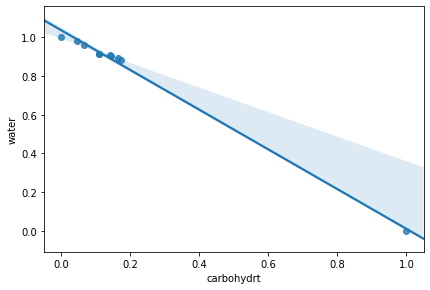

In [33]:
fig, axs = plt.subplots()
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=None)
sns.regplot(x='carbohydrt', y='water', data=peach)

## Finding which fruit has maximum given element

In [34]:
# From overall data stored previously in csv_data dataframe is considered and pre processed again.
csv_data = csv_data[["fruit_name","calcium","carbohydrt","copper","energ_kcal","iron","magnesium","manganese","phosphorus",\
                "protein","selenium","sodium","vit_b12","vit_b6","vit_c","vit_e","vit_k","water","zinc"]]

for k in csv_data:
    if k not in ['fruit_name','s']:
        x = csv_data[k].values.astype(float) #returns a numpy array
        x = x.reshape(-1, 1)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        csv_data[k] = pd.DataFrame(x_scaled)
csv_data

,fruit_name,calcium,carbohydrt,copper,energ_kcal,iron,magnesium,manganese,phosphorus,protein,selenium,sodium,vit_b12,vit_b6,vit_c,vit_e,vit_k,water,zinc
0,hazelnut,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000
1,hazelnut,0.043011,0.849786,0.000000,0.434091,0.035212,0.162791,0.000000,0.643498,0.393976,0.000000,0.216581,0.000,0.049244,0.001669,0.009534,0.000000,0.075378,0.1720
2,hazelnut,0.072581,0.760367,0.268000,0.610227,0.050074,0.106312,0.040740,0.340807,0.217269,0.150000,0.026350,0.054,0.031795,0.000000,0.105085,0.031561,0.010797,0.0848
3,hazelnut,0.296371,0.281101,0.685714,0.709091,0.035669,0.390365,0.356707,0.921525,0.597992,0.000000,0.001285,0.000,0.213261,0.000000,0.000000,0.000000,0.059738,0.1648
4,hazelnut,0.076613,0.204281,0.985714,0.709091,0.053733,0.270764,0.289824,0.650224,0.600402,0.100000,0.000000,0.000,0.218302,0.003755,0.318432,0.235880,0.053582,0.1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,melon,0.006720,0.097125,0.034286,0.032955,0.003315,0.023256,0.001877,0.026906,0.033735,0.000000,0.019923,0.000,0.041101,0.003696,0.000000,0.000000,0.910797,0.0136
101,melon,0.008737,0.049664,0.020000,0.019318,0.002401,0.016611,0.001690,0.020179,0.033735,0.016667,0.007069,0.000,0.019387,0.004828,0.000000,0.081395,0.955197,0.0112
102,melon,0.004704,0.092355,0.024000,0.029545,0.002744,0.016611,0.001784,0.024664,0.024498,0.016667,0.000643,0.000,0.017449,0.004828,0.001059,0.001661,0.922805,0.0080
103,melon,0.008737,0.092477,0.011429,0.045455,0.012919,0.066445,0.001830,0.082960,0.071486,0.000000,0.001285,0.000,0.024428,0.003159,0.000000,0.000000,0.897780,0.0384


From the overall data, we can see that Olives have maximum sodium element.

[Text(0, 0, 'hazelnut'),
 Text(0, 0, 'cherry'),
 Text(0, 0, 'bean'),
 Text(0, 0, 'raspberry'),
 Text(0, 0, 'chickpea'),
 Text(0, 0, 'litchi'),
 Text(0, 0, 'peach'),
 Text(0, 0, 'butternut'),
 Text(0, 0, 'olive'),
 Text(0, 0, 'pear'),
 Text(0, 0, 'strawberry'),
 Text(0, 0, 'melon')]

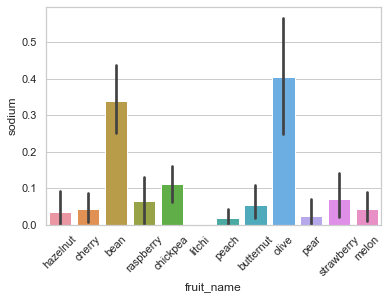

In [35]:
sns.set(style="whitegrid")
ax = sns.barplot(x="fruit_name", y="sodium", data=csv_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

From the overall data, we can see that Pear have maximum calcium.

[Text(0, 0, 'hazelnut'),
 Text(0, 0, 'cherry'),
 Text(0, 0, 'bean'),
 Text(0, 0, 'raspberry'),
 Text(0, 0, 'chickpea'),
 Text(0, 0, 'litchi'),
 Text(0, 0, 'peach'),
 Text(0, 0, 'butternut'),
 Text(0, 0, 'olive'),
 Text(0, 0, 'pear'),
 Text(0, 0, 'strawberry'),
 Text(0, 0, 'melon')]

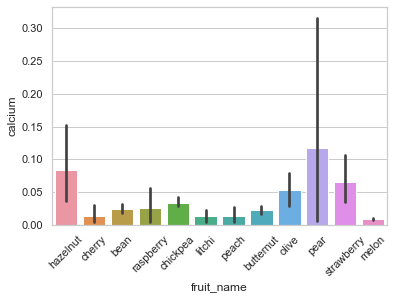

In [36]:
sns.set(style="whitegrid")
ax = sns.barplot(x="fruit_name", y="calcium", data=csv_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

From the overall data, Pear has maximum iron content. Iron is comparitively very less in other fruits in the given data.

[Text(0, 0, 'hazelnut'),
 Text(0, 0, 'cherry'),
 Text(0, 0, 'bean'),
 Text(0, 0, 'raspberry'),
 Text(0, 0, 'chickpea'),
 Text(0, 0, 'litchi'),
 Text(0, 0, 'peach'),
 Text(0, 0, 'butternut'),
 Text(0, 0, 'olive'),
 Text(0, 0, 'pear'),
 Text(0, 0, 'strawberry'),
 Text(0, 0, 'melon')]

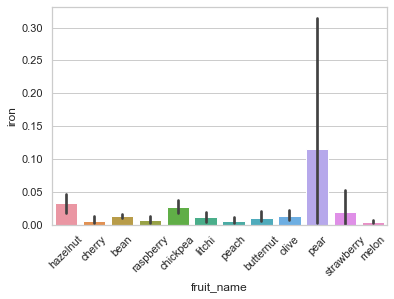

In [37]:
sns.set(style="whitegrid")
ax = sns.barplot(x="fruit_name", y="iron", data=csv_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

From the considered fruits, Strawberry has maximum content of vitamin B12. This element is almost negligible in other given fruits.

[Text(0, 0, 'hazelnut'),
 Text(0, 0, 'cherry'),
 Text(0, 0, 'bean'),
 Text(0, 0, 'raspberry'),
 Text(0, 0, 'chickpea'),
 Text(0, 0, 'litchi'),
 Text(0, 0, 'peach'),
 Text(0, 0, 'butternut'),
 Text(0, 0, 'olive'),
 Text(0, 0, 'pear'),
 Text(0, 0, 'strawberry'),
 Text(0, 0, 'melon')]

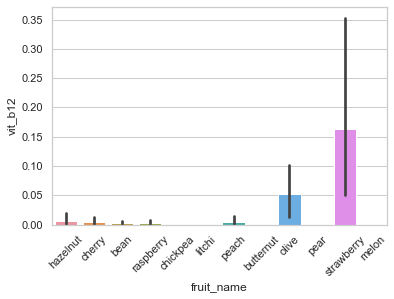

In [38]:
sns.set(style="whitegrid")
ax = sns.barplot(x="fruit_name", y="vit_b12", data=csv_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

From the considered fruits, Pear has maximum content of Calcium.

As the given data varies over the amount of fruits, the maximum number of fruits given in dataset is as follows:

[Text(0, 0, 'hazelnut'),
 Text(0, 0, 'cherry'),
 Text(0, 0, 'bean'),
 Text(0, 0, 'raspberry'),
 Text(0, 0, 'chickpea'),
 Text(0, 0, 'litchi'),
 Text(0, 0, 'peach'),
 Text(0, 0, 'butternut'),
 Text(0, 0, 'olive'),
 Text(0, 0, 'pear'),
 Text(0, 0, 'strawberry'),
 Text(0, 0, 'melon')]

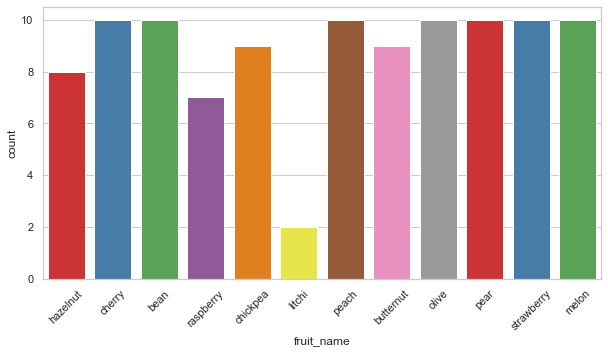

In [39]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=csv_data,
    x='fruit_name',
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


Litchi has minimum records and most of the fruits like Cherry, Bean, Peach etc have 10 records each meaning the element calculation can vary there.

### Conclusion

In the analysis of different fruit elements, some things are particularily observed as given below:
1. Water is inversely proportional with most of the elements.
2. Pear has maximum Calcium and Iron elements in the provided data, similarily, sodium is maximum in olive, vitamin B12 in Strawberry.
3. Vitamin B12 and Iron are very less in other given fruit type meals.

Insights:
As only limited fruits are considered, it is quite possible that there are other fruits having different values contain relative similarity with these fruits' elements. Each fruit has only 10 records given by the API so it is difficult to analyze much out of a single fruit value.

Future Scope:
A meal selection system can be implemented to check the Body Analysis of a human and accordingly suggest him foods that which elements he/she should take intake of. Future visualizations-
1. To search - values of correlation in more than one fruit -> direct and indirect proportionality comparison between 2 elements in more than 2 fruits.
2. Plotting fruit against an element with some aggregation like - maximum or average

### References:

1. https://pypi.org/project/pycorpora/
2. https://rapidapi.com/kenpi04/api/food-calorie-data-search/endpoints
3. https://stackoverflow.com/questions/39689352/plotting-bar-plot-in-seaborn-python-with-rotated-xlabels/39689464
4. https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame/48651066